<a href="https://colab.research.google.com/github/rodrigovitorino137/alura_challenges_ds1/blob/main/Notebooks/semana3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color='green'>**Semana 3 - Machine Learning** </font>

#<font color='green'>**Lendo os dados**</font>

In [50]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
url = 'https://raw.githubusercontent.com/rodrigovitorino137/alura_challenges_ds1/main/Dados/Telco_Customer_Churn_limpeza.csv'
df = pd.read_csv(url)
df.sample(5)

,Unnamed: 0,clienteID,Churn,genero,idoso,parceiro,dependentes,meses_contrato,serviço_telefônico,multiplas_linhas,...,proteção_dispositivos,suporte_tecnico,streaming_tv,streaming_filmes,contrato,faturamento_sem_papel,metodo_pagamento,custo_diario,custos_mensais,custos_totais
6964,6964,9881-VCZEP,Nao,Mulher,0,Sim,Nao,25,Sim,Sim,...,Nao,Nao,Nao,Nao,Mes-a-mes,Nao,Cheque eletronico,3.081667,54.10,1373.00
5282,5282,7452-FOLON,Nao,Homem,0,Nao,Sim,39,Sim,Sim,...,Sem servico internet,Sem servico internet,Sem servico internet,Sem servico internet,Um ano,Nao,Tranferencia bancaria(automatico),0.650000,25.45,958.45
6930,6930,9831-BPFRI,Sim,Mulher,0,Sim,Sim,39,Sim,Sim,...,Sim,Sim,Nao,Nao,Um ano,Sim,Cheque eletronico,3.420000,89.55,3474.45
3464,3464,4910-AQFFX,Sim,Homem,0,Sim,Sim,9,Sim,Sim,...,Sim,Nao,Nao,Nao,Mes-a-mes,Sim,Tranferencia bancaria(automatico),0.648333,79.35,661.25
5996,5996,8457-XIGKN,Nao,Homem,0,Nao,Nao,20,Sim,Nao,...,Sem servico internet,Sem servico internet,Sem servico internet,Sem servico internet,Mes-a-mes,Sim,Cartao de credito(automatico),3.108333,19.60,356.15


In [3]:
df.drop(['Unnamed: 0', 'clienteID'], inplace=True, axis = 1)
df.reset_index(inplace = True, drop=True)

# Seleção de Recursos
Durante a segunda semana, realizamos uma análise das variáveis e identificamos aquelas que podem não contribuir significativamente para o treinamento do modelo. Portanto, as seguintes variáveis serão excluídas:

* clienteID - Trata-se de uma variável categórica sem repetições.
* Gênero - A proporção de cancelamento entre homens e mulheres é praticamente a mesma.
* Custo Diário - É derivada e linearmente dependente de "Custos Mensais".
* Custo Total -  É derivada e linearmente dependente de "Custos Mensais" e "Meses de Contrato".
* Sêrviço de Telefone - A proporção de cancelamento entre clientes com e sem linha telefônica é aproximadamente a mesma.

A próxima etapa envolve a análise de correlação dessas variáveis para confirmar se apresentam uma correlação fraca com a variável Churn ou se possuem uma correlação forte entre si.



In [4]:
map = {'Sim': 1, 'Nao': 0, 'Mulher':1, 'Homem':0}
df[['serviço_telefônico', 'genero', 'Churn']] = df[['serviço_telefônico', 'genero', 'Churn']] .replace(map)
df[['Churn', 'genero', 'custos_totais',  'serviço_telefônico', 'meses_contrato']].corr()

,Churn,genero,custos_totais,serviço_telefônico,meses_contrato
Churn,1.000000,0.008612,-0.198347,0.011942,-0.352229
genero,0.008612,1.000000,0.000087,0.006488,-0.005106
custos_totais,-0.198347,0.000087,1.000000,0.113203,0.826164
serviço_telefônico,0.011942,0.006488,0.113203,1.000000,0.008448
meses_contrato,-0.352229,-0.005106,0.826164,0.008448,1.000000


In [5]:
df_drop = df.copy()
df_drop.drop(['genero', 'custos_totais',  'serviço_telefônico', 'custo_diario' ], axis = 1, inplace = True)

A taxa de cancelamento entre os clientes que não adquiriram proteção de dispositivos, suporte técnico, backup online e segurança online é semelhante. Portanto, planejamos criar uma variável indicadora para identificar se o cliente possui algum desses serviços. Posteriormente, as variáveis mencionadas serão removidas do conjunto de dados.

In [6]:
pd.DataFrame({'Proporção': [df.query('proteção_dispositivos=="Nao"').Churn.value_counts(normalize = True)[1],
                            df.query('suporte_tecnico=="Nao"').Churn.value_counts(normalize = True)[1],
                            df.query('backup_online=="Nao"').Churn.value_counts(normalize = True)[1],
                            df.query('segurança_online=="Nao"').Churn.value_counts(normalize = True)[1]]},
              index = ['proteção_dispositivos','suporte_tecnico', 'backup_online','segurança_online' ])

,Proporção
proteção_dispositivos,0.391276
suporte_tecnico,0.416355
backup_online,0.399288
segurança_online,0.417667


In [7]:
df_drop['protecao'] = df.apply(lambda x: 1 if x['proteção_dispositivos'] == 'Sim' or x['suporte_tecnico'] == 'Sim' or x['backup_online'] == 1 or x['segurança_online'] == 1 else 0, axis=1)
df_drop.drop(['proteção_dispositivos','suporte_tecnico', 'backup_online','segurança_online' ], axis = 1, inplace = True)

Observamos uma tendência semelhante em relação ao streaming de TV e filmes, onde a taxa de cancelamento entre clientes que não utilizam esses serviços é próxima. Assim, planejamos criar uma variável indicadora para identificar se o cliente utiliza qualquer um desses serviços, e em seguida, remover essas variáveis do conjunto de dados.

In [8]:
pd.DataFrame({'Proporção': [df.query('streaming_tv=="Nao"').Churn.value_counts(normalize = True)[1],
                            df.query('streaming_filmes=="Nao"').Churn.value_counts(normalize = True)[1],
                           ]},
              index = ['streaming_tv','streaming_filmes' ])

,Proporção
streaming_tv,0.335231
streaming_filmes,0.336804


In [9]:
df_drop['streaming'] = df.apply(lambda x: 1 if x['streaming_filmes'] == 'Sim' or x['streaming_tv'] == 'Sim' else 0, axis=1)
df_drop.drop( ['streaming_tv','streaming_filmes'], axis = 1, inplace = True)

In [10]:
df_drop.columns

Index(['Churn', 'idoso', 'parceiro', 'dependentes', 'meses_contrato',
       'multiplas_linhas', 'serviço_internet', 'contrato',
       'faturamento_sem_papel', 'metodo_pagamento', 'custos_mensais',
       'protecao', 'streaming'],
      dtype='object')

#<font color='green'>**Separando variáveis**</font>

In [12]:
x = df_drop.drop('Churn', axis =1)
y = df_drop['Churn']

Identificamos um desequilíbrio na variável alvo. Portanto, planejamos balanceá-la e avaliar qual abordagem é mais adequada: oversampling ou undersampling.

In [16]:
y.value_counts(normalize = True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

#<font color='green'>**Aplicando encoding nos dados**</font>

In [19]:
colunas_categoricas =[]
for col in df_drop.columns:
  if df_drop[col].dtype == 'object':
    colunas_categoricas.append(col)
colunas_categoricas


['parceiro',
 'dependentes',
 'multiplas_linhas',
 'serviço_internet',
 'contrato',
 'faturamento_sem_papel',
 'metodo_pagamento']

In [22]:
colunas = x.columns
one_hot = make_column_transformer((
    OneHotEncoder(drop = 'if_binary'),
    colunas_categoricas
),
    remainder = 'passthrough',
    sparse_threshold=0)
x = one_hot.fit_transform(x)
nomes_colunas = [col.replace("onehotencoder__", "").replace("remainder__", "") for col in one_hot.get_feature_names_out(colunas)]
x =pd.DataFrame(x, columns = nomes_colunas)

In [45]:
x.columns

Index(['parceiro_Sim', 'dependentes_Sim', 'multiplas_linhas_Nao',
       'multiplas_linhas_Sem servico telefonico', 'multiplas_linhas_Sim',
       'serviço_internet_DSL', 'serviço_internet_Fibra optica',
       'serviço_internet_Nao', 'contrato_Dois anos', 'contrato_Mes-a-mes',
       'contrato_Um ano', 'faturamento_sem_papel_Sim',
       'metodo_pagamento_Cartao de credito(automatico)',
       'metodo_pagamento_Cheque eletronico', 'metodo_pagamento_Cheque enviado',
       'metodo_pagamento_Tranferencia bancaria(automatico)', 'idoso',
       'meses_contrato', 'custos_mensais', 'protecao', 'streaming'],
      dtype='object')

In [44]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, stratify=y)

#<font color='green'>**Criando  e Testando Modelos de Machine Learning**</font>

Criando uma função onde nós iremos avaliar as métricas dos modelos.

In [26]:
def intervalo_conf(modelos, nomes):
  medias_acuracia = []
  medias_recall = []
  intervalos_acuracia = []
  intervalos_recall = []

  for modelo, nome in zip(modelos, nomes):

    validacao_c = cross_validate(modelo, x_treino, y_treino, cv = skf, scoring =('recall','accuracy'), n_jobs=-1)

    media_acuracia = validacao_c['test_accuracy'].mean()
    medias_acuracia.append(round(media_acuracia, 2))

    media_recall = validacao_c['test_recall'].mean()
    medias_recall.append(round(media_recall, 2))

    desvio_padrao_acuracia = validacao_c['test_accuracy'].std()
    desvio_padrao_recall = validacao_c['test_recall'].std()

    intervalos_acuracia.append(f'({(media_acuracia - 2*desvio_padrao_acuracia):.2f}, {min(media_acuracia + 2*desvio_padrao_acuracia, 1):.2f})')
    intervalos_recall.append(f'({(media_recall - 2*desvio_padrao_recall):.2f}, {min(media_recall + 2*desvio_padrao_recall, 1):.2f})')

  return pd.DataFrame({'Média - Acurácia': medias_acuracia, 'Intervalo de confiança - Acurácia':intervalos_acuracia,
                         'Média - Recall': medias_recall, 'Intervalo de confiança - Recall':intervalos_recall,
                          } , index = nomes)

In [29]:
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 101)

Criando os modelos para comparação.

In [32]:
model_xgb_over = Pipeline([('over', SMOTE()), ('xgboost', XGBClassifier(objective='binary:logistic'))])
model_xgb_under = Pipeline([('under', NearMiss(version = 3)), ('xgboost', XGBClassifier(objective='binary:logistic'))])

In [33]:
model_lr_over = Pipeline([ ('oversample', SMOTE()), ('scaler', StandardScaler()), ('lr', LogisticRegression())])
model_lr_under = Pipeline([ ('undersample', NearMiss(version = 3)), ('scaler', StandardScaler()),
                           ('lr', LogisticRegression())])

In [36]:
model_knn_over = Pipeline([('oversample', SMOTE()), ('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

model_knn_under = Pipeline([('undersample', NearMiss(version = 3)), ('scaler', StandardScaler()),
 ('knn', KNeighborsClassifier(n_jobs = -1))])


In [39]:
model_abc_over = Pipeline([('over', SMOTE()), ('abc', AdaBoostClassifier())])
model_abc_under = Pipeline([('under', NearMiss(version = 3)), ('abc', AdaBoostClassifier())])

In [40]:
model_svc_over = Pipeline([('oversample', SMOTE()), ('scaler', StandardScaler()), ('svc', SVC())])

model_svc_under = Pipeline([('undersample', NearMiss(version = 3)), ('scaler', StandardScaler()),
 ('svc', SVC())])

In [46]:
modelos = [model_xgb_over, model_xgb_under, model_lr_over, model_lr_under, model_knn_over, model_knn_under,
           model_abc_over, model_abc_under, model_svc_over, model_svc_under]
nomes = ['XGBOOST(OVER)', 'XGBOOST(UNDER)', 'LogisticRegression(OVER)', 'LogisticRegression(UNDER)',
         'KNeighborsClassifier(OVER)', 'KNeighborsClassifier (UNDER)', 'AdaBoostClassifier(OVER)', 'AdaBoostClassifier(UNDER)', 'SVC(OVER)', 'SVC(UNDER)']
resultados = intervalo_conf(modelos, nomes)

Vamos direcionar nossa atenção para a métrica de recall, pois nosso objetivo é identificar o maior número possível de clientes potenciais propensos ao churn.

In [48]:
resultados.sort_values(by ='Média - Recall' ,ascending=False)

,Média - Acurácia,Intervalo de confiança - Acurácia,Média - Recall,Intervalo de confiança - Recall
LogisticRegression(OVER),0.75,"(0.71, 0.78)",0.79,"(0.72, 0.87)"
LogisticRegression(UNDER),0.77,"(0.72, 0.81)",0.70,"(0.62, 0.79)"
SVC(OVER),0.78,"(0.74, 0.81)",0.70,"(0.63, 0.76)"
SVC(UNDER),0.75,"(0.72, 0.79)",0.69,"(0.62, 0.77)"
AdaBoostClassifier(OVER),0.78,"(0.74, 0.82)",0.68,"(0.59, 0.77)"
AdaBoostClassifier(UNDER),0.77,"(0.74, 0.80)",0.67,"(0.60, 0.74)"
KNeighborsClassifier(OVER),0.73,"(0.68, 0.78)",0.63,"(0.53, 0.73)"
XGBOOST(UNDER),0.72,"(0.67, 0.76)",0.62,"(0.53, 0.72)"
KNeighborsClassifier (UNDER),0.72,"(0.67, 0.76)",0.62,"(0.53, 0.71)"
XGBOOST(OVER),0.78,"(0.74, 0.82)",0.55,"(0.48, 0.61)"


Observamos que os modelos mais promissores para nossos objetivos são o Logistic Regression e o Support Vector Classifier (SVC), ambos utilizando a técnica de balanceamento undersampling. Ambos apresentam métricas satisfatórias, no entanto, planejamos otimizá-los ainda mais por meio de ajustes nos hiperparâmetros.

#<font color='green'>**Otimizando o melhor modelo**</font>

A seguir, procederemos com a otimização dos modelos através da configuração de hiperparâmetros. Dado o tamanho reduzido da base de dados, optaremos pela utilização do GridSearchCV. Para assegurar maior rigor em nossos resultados, implementaremos uma validação cruzada aninhada.

In [49]:
max_iter = np.linspace(100, 300, 10, dtype=int)
c = [0.0001 ,0.001, 0.01, 0.1, 1, 10]

param_grid_lr = [
    {'logisticregression__solver' : ['newton-cg', 'lbfgs', 'newton-cholesky' ],
      'logisticregression__penalty' : ['l2'],
      'logisticregression__max_iter' : max_iter,
       'logisticregression__C' : c},
    {'logisticregression__solver' : ['liblinear'],
      'logisticregression__penalty' : ['l1', 'l2'],
      'logisticregression__max_iter' : max_iter,
      'logisticregression__C' : c},
]

In [ ]:
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr_nested_gs = GridSearchCV(estimator = Pipeline([ ('undersample', NearMiss(version = 3)), ('scaler', StandardScaler()),
                           ('logisticregression', LogisticRegression())]),
                               param_grid = param_grid_lr,
                               scoring = "recall",
                               n_jobs = -1,
                               cv = inner_cv)

lr_nested_scores = cross_val_score(lr_nested_gs, x_treino, y_treino, cv=outer_cv)

In [ ]:
print("Métricas de desempenho para cada iteração do CV externo:", lr_nested_scores)
print(f"Média da métrica recall de desempenho do CV externo: {lr_nested_scores.mean():.4f}")
lr_nested_gs.fit(x_treino, y_treino)
best_params_lr = lr_nested_gs.best_params_
print("Melhores hiperparâmetros:", best_params_lr)

In [ ]:
param_grid_svc = {'svc__C': [0.1, 1, 10, 100, 1000],
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'svc__kernel': ['rbf']}

svc_nested_gs = GridSearchCV(estimator = Pipeline([ ('undersample', NearMiss(version = 3)), ('scaler', StandardScaler()),
                           ('svc', SVC())]),
                               param_grid = param_grid_svc,
                               scoring = "recall",
                               n_jobs = -1,
                               cv = inner_cv)

svc_nested_scores = cross_val_score(svc_nested_gs, x_treino, y_treino, cv=outer_cv)

In [ ]:
print("Métricas de desempenho para cada iteração do CV externo:", svc_nested_scores)
print(f"Média da métrica recall de desempenho do CV externo: {svc_nested_scores.mean():.4f}")
svc_nested_gs.fit(x_treino, y_treino)
best_params_svc = svc_nested_gs.best_params_
print("Melhores hiperparâmetros:", best_params_svc)

Realizaremos o retrabalho dos nossos modelos otimizados, seguido por uma nova execução da validação cruzada.

In [ ]:
best_svc_under = Pipeline([('undersample', NearMiss(version = 3)), ('scaler', StandardScaler()),
 ('svc', SVC(C= 0.1, gamma = 0.0001, kernel= 'rbf'))])

best_lr_under = Pipeline([('undersample', NearMiss(version = 3)), ('scaler', StandardScaler()),
 ('lr', LogisticRegression(C= 0.01, max_iter= 100, penalty='l1', solver= 'liblinear'))])

In [ ]:
best_models = [best_svc_under, best_lr_under]
best_models_nomes = ['SVC', 'LR']

In [ ]:
best_results = intervalo_conf(best_models, best_models_nomes)

In [ ]:
best_results

A média do recall apresentou uma melhoria significativa nos dois modelos; no entanto, no SVM, observou-se um aumento expressivo no recall, acompanhado de uma redução correspondente na acurácia.

#<font color='green'>**Testando modelos**</font>

Vamos testar os dois modelos agora com os dados de teste usando o undersampling.

In [51]:
under = NearMiss(version=3)
x_balanceado, y_balanceado = under.fit_resample(x_treino, y_treino)

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1294
           1       0.52      0.73      0.61       467

    accuracy                           0.75      1761
   macro avg       0.70      0.74      0.71      1761
weighted avg       0.79      0.75      0.76      1761



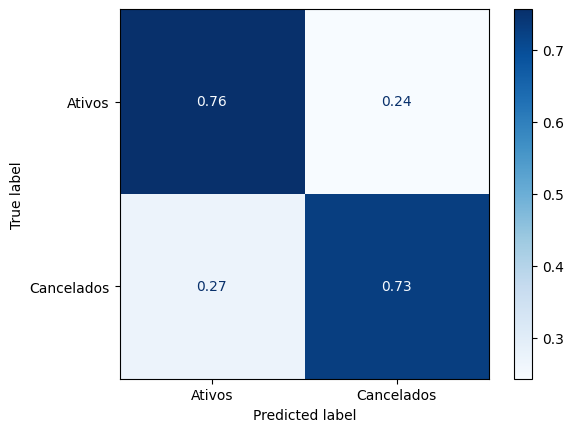

In [52]:
modelo_lr = Pipeline([ ('scaler', StandardScaler()),
 ('lr', LogisticRegression(C= 0.01, max_iter= 100, penalty='l1', solver= 'liblinear'))])
modelo_lr.fit(x_balanceado, y_balanceado)
y_previsto_lr = modelo_lr.predict(x_teste)

print(classification_report(y_teste, y_previsto_lr))
ConfusionMatrixDisplay.from_estimator(modelo_lr, x_teste, y_teste, display_labels=['Ativos', 'Cancelados'],
                                      normalize='true', cmap='Blues');

In [ ]:
modelo_svc = Pipeline([ ('scaler', StandardScaler()),
 ('svc', SVC(C= 0.1, gamma = 0.0001, kernel= 'rbf'))])
modelo_svc.fit(x_balanceado, y_balanceado)
y_previsto_svc = modelo_svc.predict(x_teste)

print(classification_report(y_teste, y_previsto_svc))
ConfusionMatrixDisplay.from_estimator(modelo_svc, x_teste, y_teste, display_labels=['Ativos', 'Cancelados'],
                                      normalize='true', cmap='Blues');

In [53]:
joblib.dump(modelo_lr, 'modelo_xgb.pkl')

['modelo_xgb.pkl']

In [54]:
joblib.dump(one_hot, 'modelo_onehotenc.pkl')

['modelo_onehotenc.pkl']

As observações feitas durante o treinamento foram corroboradas nos dados de teste. O SVM registrou um aumento no recall, contudo, suas outras métricas mostraram-se substancialmente inferiores às da Regressão Logística. Por outro lado, o recall da Regressão Logística não ficou significativamente aquém do obtido pelo SVM.
Dito isso, o melhor modelo para apresentar ao Alura Voz será o de Regressão Logística.